# SIMULACION DE TRÁFICO - VERSIÓN 1

In [74]:
# Importando librerías
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATOS DE POBLACION DEL EDIFICIO

In [75]:
#building = pd.read_csv(r'/content/drive/My Drive/Colab Notebooks/ta_format.csv')
#building = pd.read_csv(r'C:\Users\jsvil\OneDrive\Documents\UW\EL_TRAFFIC\ta_format.csv') ------ to open using Visual Studio
data = [
    ['S','EF',4,0],
    ['L','MF',5,10],
    ['2','DF',3,15],
    ['3','DF',3,10],
    ['4','DF',3,15],
    ['5','DF',3,10],
    ['6','DF',3,5],
    ['7','DF',3,10],
    ['8','DF',3,15],
    ['9','DF',3,10],
    ['10','DF',3,9]
]
building = pd.DataFrame(data,columns=['NUMENCLATURE','TYPE','HEIGHT','NUMBER OF PEOPLE'])
building.head(15)

,NUMENCLATURE,TYPE,HEIGHT,NUMBER OF PEOPLE
0,S,EF,4,0
1,L,MF,5,10
2,2,DF,3,15
3,3,DF,3,10
4,4,DF,3,15
5,5,DF,3,10
6,6,DF,3,5
7,7,DF,3,10
8,8,DF,3,15
9,9,DF,3,10


# DATOS DEL ASCENSOR Y ESTUDIO DE TRÁFICO

In [76]:
#Number of simulations
capacity = 8 #capacity of elevator (number of passengers)
speed = 2
acceleration = 1
n_simulations = 10000


################### Don't touch me, I am Newton #####################
t_reach_speed = speed/acceleration
x_reach_speed = (acceleration*(t_reach_speed**2))/2

In [77]:
print('la distancia para alcanzar la velocidad nominal es:',x_reach_speed,'metros')

la distancia para alcanzar la velocidad nominal es: 2.0 metros


## Lista de probabilidades por piso (automático)

In [78]:
#######################
time_acc = speed/acceleration
dist_acc = 0.5*acceleration*(time_acc**2)

#Creating the lists of possible floor destinations and their probability associated

#List of destination floors
possible_df = list(building[building['TYPE']=='DF']['NUMENCLATURE'])

#list of probabilities of each destination floor
n_people_df = list(building[building['TYPE']=='DF']['NUMBER OF PEOPLE'])
probabilities_df = []
for i in range(len(n_people_df)):
  probabilities_df.append(n_people_df[i]/sum(n_people_df))
print(n_people_df,probabilities_df)

[15, 10, 15, 10, 5, 10, 15, 10, 9] [0.15151515151515152, 0.10101010101010101, 0.15151515151515152, 0.10101010101010101, 0.050505050505050504, 0.10101010101010101, 0.15151515151515152, 0.10101010101010101, 0.09090909090909091]


In [79]:
#Skewed - This will create the probability distribution of number of passengers per trip
passengers_alpha = capacity*0.2
passengers_beta = capacity*0.8
univ_pass_skewed = capacity*np.random.beta(passengers_beta,passengers_alpha,n_simulations)

# Código de simulación

A partir de la línea For k in range 0,n_simulations, el código se repite n veces y guarda los resultados del RTT para cada iteración.

Los pasos de cada iteración son:

* El algoritmo selecciona un número aleatorio de personas (K) por viaje basada en una distribución de probabilidad del bloque de código anterior.
* El algoritmo selecciona los K pisos destino de el viaje. Para seleccionar los pisos destino el algoritmo tiene en cuenta la probabilidad de viajar a cada piso dada la distribución de población en el edificio.
* Luego el algoritmo crea la lista por piso de número de personas que van a entrar o salir en cada piso
* Basado en la lista anterior, el algoritmo calcula la lista de distancias que va a recorrer entre cada parada para un viaje

* Luego el algoritmo calcula el RTT (esta ecuación no está optimizada todavía)


In [80]:
RTT_list = []
n_times_reached_speed_list = []

#######CREATING LIST OF PASSENGERS PER TRIP
#Step 1: Selecting randomly the number of passengers per trip
for k in range(0,n_simulations):
  n_passengers = int(np.random.choice(univ_pass_skewed))
  #Here we could store the number of passengers per trip, it will make the simulation to run slower
  actual_df = []
  # The following code choses k random destination floors based on the floor probabilities
  for n in range(n_passengers):
    partial_df = np.random.choice(possible_df,p = probabilities_df)
    actual_df.append(partial_df)
  #Here we could store the destination floors. It would make the simulation to run slower



  ####################### Creating the list of distances that elvator will travel among each trip and the amount of people that will stop on each floor#####
  n_stops_df_list = []
  for i in range(len(building['NUMENCLATURE'])):
    count = 0
    for j in range(len(actual_df)):
      if building['TYPE'][i] == 'MF':
        count +=1
      elif actual_df[j] == building['NUMENCLATURE'][i]:
        count += 1
    n_stops_df_list.append(count)


  height_list_building = list(building['HEIGHT'])
  #Creating a list of the distances between stops u-lift for each travel
  tr_time = 0
  tr_x = 0
  stop_number =  0
  distances_to_travel = []
  partial_distance = 0
  non_stops = 0
  #the number of passengers that traveled will set up the last iteration:
  passengers_traveled = 0
  for i in range(len(height_list_building)):
    if stop_number == 0 and n_stops_df_list[i] != 0:
      partial_distance += height_list_building[i]
      stop_number += 1
    elif stop_number > 0 and n_stops_df_list[i] == 0:
      partial_distance += height_list_building[i]
    elif  stop_number > 0 and n_stops_df_list[i] != 0:
      distances_to_travel.append(partial_distance)
      partial_distance = height_list_building[i]
      stop_number+=1
    else:
      non_stops += 1
  #These formulas are inaccurate for Traffic Simulation
  partial_time = 0
  n_times_reached_speed = 0
  for i in range(len(distances_to_travel)):
    t = 0
    if distances_to_travel[i] <= 2*x_reach_speed:
      t = 2*((0.5*2*distances_to_travel[i]/acceleration)**0.5) #0.5 times 2 is a redundancy but increases equation comprehension
      partial_time += t
    else:
      t = 2*t_reach_speed + (distances_to_travel[i]-2*x_reach_speed)/speed
      partial_time += t
      n_times_reached_speed +=1

  #Creating the list of results
  n_times_reached_speed_list.append(n_times_reached_speed/len(distances_to_travel))
  RTT = partial_time/speed + sum(distances_to_travel)/speed + stop_number*2 + 0.5*sum(n_stops_df_list)
  RTT_list.append(RTT)
print(distances_to_travel)

[5, 9, 9, 6]


Text(0, 0.5, 'frequency *10000')

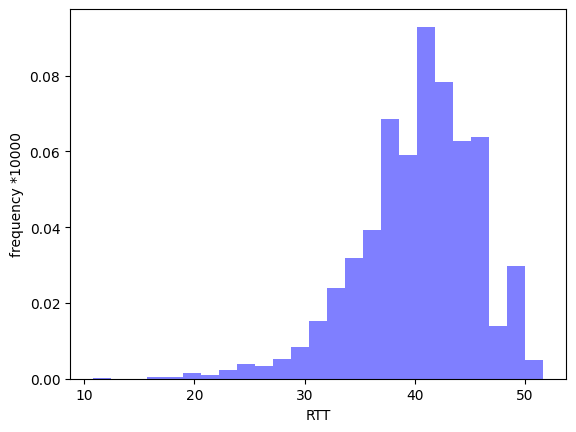

In [81]:
ylabel = 'frequency *'+ str(n_simulations)
plt.hist(RTT_list, bins=25, density=True, alpha=0.5, color='b', label='Simulated Data')
plt.xlabel('RTT')
plt.ylabel(ylabel)

{'whiskers': [<matplotlib.lines.Line2D at 0x7d4d8c22c370>,
 'caps': [<matplotlib.lines.Line2D at 0x7d4d8c22c8b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7d4d8c22c0d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7d4d8c22cdf0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7d4d8c22d090>],
 'means': []}

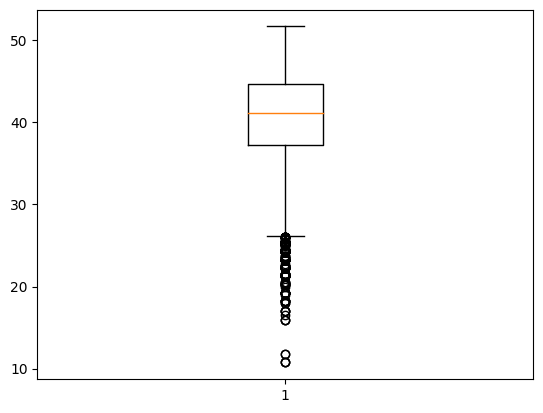

In [82]:
plt.boxplot(RTT_list)

In [83]:
pd.DataFrame(RTT_list)[0].describe()

count    10000.000000
mean        40.380597
std          5.396080
min         10.750000
25%         37.232051
50%         41.196152
75%         44.696152
max         51.678203
Name: 0, dtype: float64

In [84]:
print('El porcentaje de veces que el ascensor logra la velocidad nominal entre paradas es:',sum(n_times_reached_speed_list)/len(n_times_reached_speed_list)*100,'%')

El porcentaje de veces que el ascensor logra la velocidad nominal entre paradas es: 63.19471428571549 %


# Mejoras para futuras versiones

* Cómo funcionaría para más de un ascensor. Revisar si para eso hay que seguir un modelo matemático o hay que imitar en el código la lógica de selección de paradas del ascensor (Revisar Handbook)

* Revisar si en el Handbook respecto a cómo crear las distribuciones de probabilidad de número de pasajeros por viaje.
* Revisar si hay un número de iteraciones mínimas por norma.

* Este estudio es 100% up-peak. Se puede crear una versión en donde tenga en cuenta que en un mismo viaje sale y entran pasajeros como en el caso residencial.

* Se puede hacer que el algoritmo tenga en cuenta la probabilidad de que las personas entren por los pisos de sótanos al edificio (por el momento asume que todos entran por el Main Floor.

* Optimizar el código para que corra más rápido y guarde más datos para visualización y análisis. Por ejemplo, para que corra rápido no dejé que almacenara los pisos en que para en cada iteración.

* Optimizar la formula de RTT de acuerdo a los datos reales de los ascensores. Sacar los resultados en funcion del porcentaje de población evacuada en 5 min.


